Following propensity-score matching, a straightforward survival analysis of matched cohorts is plausible. For all Kaplan-Meier and Cox model fitting we use the `survival` R package.

In [45]:
library(survival)
load("data/analysis_3_matchit-los-m-df.RData")

`ggsurv()` is an alternative method for plotting survival curves, using `ggplot` instead of base R plotting

In [46]:
ggsurv <- function(s, CI = 'def', plot.cens = T, surv.col = 'gg.def',
                   cens.col = 'red', lty.est = 1, lty.ci = 2,
                   cens.shape = 3, back.white = F, xlab = 'Time',
                   ylab = 'Survival', main = '', gr.name = 'gg.def', 
                   gr.labels = NULL){
 
  require(cowplot)
  library(ggplot2)
  if (is.matrix(s$surv)) {
    s$strata <- rep(nrow(s$surv), times=ncol(s$surv))
    names(s$strata) <- paste(ifelse(gr.name != 'gg.def', gr.name, 'group'), 
                             if (!is.null(gr.labels)) gr.labels else 1:ncol(s$surv),
                             sep="=")
  }
  strata <- ifelse(is.null(s$strata) == T, 1, length(s$strata))
  stopifnot(length(surv.col) == 1 | length(surv.col) == strata)
  stopifnot(length(lty.est) == 1 | length(lty.est) == strata)
 
  ggsurv.s <- function(s, CI = 'def', plot.cens = T, surv.col = 'gg.def',
                       cens.col = 'red', lty.est = 1, lty.ci = 2,
                       cens.shape = 3, back.white = F, xlab = 'Time',
                       ylab = 'Survival', main = ''){
 
    dat <- data.frame(time = c(0, s$time),
                      surv = c(1, s$surv),
                      up = c(1, s$upper),
                      low = c(1, s$lower),
                      cens = c(0, s$n.censor))
    dat.cens <- subset(dat, cens != 0)
 
    col <- ifelse(surv.col == 'gg.def', 'black', surv.col)
 
    pl <- ggplot(dat, aes(x = time, y = surv)) +
      xlab(xlab) + ylab(ylab) + ggtitle(main) +
      geom_step(col = col, lty = lty.est)
 
    pl <- if(CI == T | CI == 'def') {
      pl + geom_ribbon(aes(ymin = low, ymax = up), fill=col, alpha=0.3)
    } else (pl)
 
    pl <- if(plot.cens == T & length(dat.cens) > 0){
      pl + geom_point(data = dat.cens, aes(y = surv), shape = cens.shape,
                       col = cens.col)
    } else if (plot.cens == T & length(dat.cens) == 0){
      stop ('There are no censored observations')
    } else(pl)
 
    pl <- if(back.white == T) {pl + theme_bw()
    } else (pl)
    pl
  }
 
  ggsurv.m <- function(s, CI = 'def', plot.cens = T, surv.col = 'gg.def',
                       cens.col = 'red', lty.est = 1, lty.ci = 2,
                       cens.shape = 3, back.white = F, xlab = 'Time',
                       ylab = 'Survival', main = '', gr.name = 'gg.def') {
    n <- s$strata
 
    groups <- if (all(grepl('=', names(s$strata)))) { 
                factor(unlist(strsplit(names(s$strata), '='))[seq(2, 2*strata, by = 2)])
              } else { factor(names(s$strata)) }
    gr.name <- ifelse(gr.name != 'gg.def', gr.name, unlist(strsplit(names(s$strata), '='))[1])
    gr.df <- vector('list', strata)
    ind <- vector('list', strata)
    n.ind <- c(0, n); n.ind <- cumsum(n.ind)
    for(i in 1:strata) ind[[i]] <- (n.ind[i] + 1):n.ind[i + 1]
 
    for(i in 1:strata){
      gr.df[[i]] <- data.frame(
        time = c(0, if (n.ind[i] >= length(s$time)) s$time else s$time[ ind[[i]] ]),
        surv = c(1, s$surv[ ind[[i]] ]),
        up = c(1, s$upper[ ind[[i]] ]),
        low = c(1, s$lower[ ind[[i]] ]),
        cens = c(0, if (n.ind[i] >= length(s$n.censor)) s$n.censor else s$n.censor[ ind[[i]] ]),
        group = rep(groups[i], n[i] + 1))
    }
 
    dat <- do.call(rbind, gr.df)
    dat.cens <- subset(dat, cens != 0)
    dat$group <- factor(as.character(dat$group), levels = groups)
             
    pl <- ggplot(dat, aes(x = time, y = surv, group = group)) +
      xlab(xlab) + ylab(ylab) + ggtitle(main) +
      geom_step(aes(col = group, lty = group))
 
    pl <- if (surv.col[1] != 'gg.def') {
      if (length(surv.col == 1)) {
        pl + scale_colour_manual(name = gr.name, values = rep(surv.col, strata)) +
             scale_fill_manual(name = gr.name, values = rep(surv.col, strata))
      } else{
        pl + scale_colour_manual(name = gr.name, values = surv.col) +
             scale_fill_manual(name = gr.name, values = surv.col)
      }
    } else { pl + scale_colour_discrete(name = gr.name) + scale_fill_discrete(name = gr.name) }
 
    line <- if(length(lty.est) == 1){
      scale_linetype_manual(name = gr.name, values = rep(lty.est, strata))
    } else { scale_linetype_manual(name = gr.name, values = lty.est) }
 
    pl <- pl + line
 
    pl <- if(CI == T) {
      if ((length(surv.col) > 1 | surv.col == 'gg.def')[1]) {
        pl + geom_ribbon(aes(ymin = low, ymax = up, fill = group), alpha=0.3)
      } else { pl + geom_ribbon(aes(ymin = low, ymax = up), fill = surv.col, alpha=0.3) }
    } else { pl }
 
 
    pl <- if(plot.cens == T & length(dat.cens) > 0){
      pl + geom_point(data = dat.cens, aes(y = surv), shape = cens.shape,
                      col = cens.col)
    } else if (plot.cens == T & length(dat.cens) == 0){
      stop ('There are no censored observations')
    } else(pl)
 
    pl <- if(back.white == T) {
      pl + theme_bw()
    } else (pl)
        
    pl
  }
  
  pl <- if (strata == 1) { ggsurv.s(s, CI , plot.cens, surv.col ,
                                   cens.col, lty.est, lty.ci,
                                   cens.shape, back.white, xlab,
                                   ylab, main)
  } else { ggsurv.m(s, CI, plot.cens, surv.col,
                    cens.col, lty.est, lty.ci,
                    cens.shape, back.white, xlab,
                    ylab, main, gr.name) }
  pl
}

Limit to only the cases and *matched* controls.

In [48]:
los.m.df <- los.m.df[los.m.df$cdi_status %in% c("matched cases", "matched controls"),]

Relevel the `cdi_status` factor because now it has two unused levels.

Also relevel the `gender` factor because the uncommon levels were tossed in the previous step.

In [ ]:
los.m.df$cdi_status <- factor(as.character(los.m.df$cdi_status))
los.m.df$gender <- factor(as.character(los.m.df$gender))

In [50]:
los.m.df$length_of_stay <- round(pmax(los.m.df$length_of_stay, 1), 1)
los.m.df$cdtox_positive_after <- round(pmax(0.5,
                                            pmin(los.m.df$length_of_stay - 0.5,
                                                 los.m.df$cdtox_positive_after)), 1)
summary(los.m.df$length_of_stay)
summary(los.m.df$cdtox_positive_after)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    3.90    7.90   14.06   16.20  288.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.500   1.600   5.000   8.608   9.800 250.300    3010 

# Fit survival and Cox PH models

## 1a. `cdi_dx = 'Y'`

In [51]:
los.df.cdi_dx <- los.m.df[los.m.df$case_def == 'cdi_dx',]

First, the basics: plot a fitted survival curve, first using base plotting, which is a bit ugly

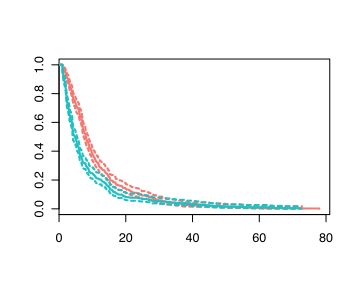

In [52]:
surv.cdi_dx.case <- Surv(los.df.cdi_dx$length_of_stay[los.df.cdi_dx$cdi_status == 'matched cases'], 
                         rep(1, sum(los.df.cdi_dx$cdi_status == 'matched cases')))
surv.cdi_dx.control <- Surv(los.df.cdi_dx$length_of_stay[los.df.cdi_dx$cdi_status == 'matched controls'], 
                         rep(1, sum(los.df.cdi_dx$cdi_status == 'matched controls')))

options(jupyter.plot_mimetypes = "image/svg+xml") 
options(repr.plot.width=5, repr.plot.height=4, repr.plot.bg='white')

fit.case <- survfit(surv.cdi_dx.case ~ 1)
fit.control <- survfit(surv.cdi_dx.control ~ 1)
plot(fit.case, col="#f67770", lwd=2)
lines(fit.control, col="#1fbfc3", lwd=2)

Using `ggsurv` instead, it's a little more pretty and easy to customize

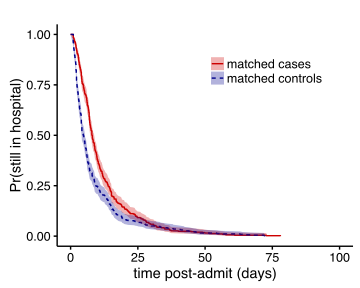

In [53]:
surv.cdi_dx <- Surv(los.df.cdi_dx$length_of_stay, rep(1, nrow(los.df.cdi_dx)))
options(repr.plot.width=5, repr.plot.height=4)
gg <- ggsurv(survfit(surv.cdi_dx ~ cdi_status, data = los.df.cdi_dx), 
             CI=TRUE, xlab="time post-admit (days)", ylab="Pr(still in hospital)", gr.name="group",
             surv.col=c("red3", "darkblue"), lty.est=c(1, 2)) +
      theme(legend.position=c(0.7, 0.8), legend.title=element_blank()) +
      coord_cartesian(xlim=c(0, 100))
save_plot("data/analysis_3_survival-cdi_dx.pdf", gg, base_height=3, base_aspect_ratio=1.3)
gg

Now fit a Cox P-H model; first we need the `Surv` object which is a N:2 matrix of times + right-censorship

In [54]:
S.cdi_dx <- Surv(los.df.cdi_dx$length_of_stay, rep(1, nrow(los.df.cdi_dx)))
str(S.cdi_dx)

 Surv [1:914, 1:2]  3.3  19.1  28.1  11.7  61.0   1.0   4.1   2.9   6.3  10.5  ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:2] "time" "status"
 - attr(*, "type")= chr "right"


In [87]:
los.df.cdi_dx$cdi_case = los.df.cdi_dx$cdi_status == "matched cases"
summary(los.df.cdi_dx$cdi_case)

   Mode   FALSE    TRUE    NA's 
logical     457     457       0 

In [88]:
cox.cdi_dx <- coxph(S.cdi_dx ~ propensity + age + gender + cdi_case, 
                    data=los.df.cdi_dx)
summary(cox.cdi_dx)

Call:
coxph(formula = S.cdi_dx ~ propensity + age + gender + cdi_case, 
    data = los.df.cdi_dx)

  n= 914, number of events= 914 

                  coef exp(coef)  se(coef)      z Pr(>|z|)    
propensity   -3.356123  0.034870  1.313225 -2.556   0.0106 *  
age          -0.001851  0.998151  0.001655 -1.118   0.2634    
genderMale   -0.140312  0.869087  0.066950 -2.096   0.0361 *  
cdi_caseTRUE -0.341631  0.710610  0.066655 -5.125 2.97e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

             exp(coef) exp(-coef) lower .95 upper .95
propensity     0.03487     28.678  0.002658    0.4574
age            0.99815      1.002  0.994918    1.0014
genderMale     0.86909      1.151  0.762212    0.9909
cdi_caseTRUE   0.71061      1.407  0.623583    0.8098

Concordance= 0.603  (se = 0.011 )
Rsquare= 0.041   (max possible= 1 )
Likelihood ratio test= 37.8  on 4 df,   p=1.23e-07
Wald test            = 37.3  on 4 df,   p=1.559e-07
Score (logrank) test = 37.57  on 4 df,  

In [89]:
dummy.cdi_dx.female <- with(los.df.cdi_dx,
                            data.frame(
                                cdi_case=c(FALSE, TRUE),
                                age=mean(age),
                                propensity=median(propensity),
                                gender=rep(levels(gender)[1], 2)
                                )
                            )
dummy.cdi_dx.female
dummy.cdi_dx.male <- with(los.df.cdi_dx,
                          data.frame(
                                   cdi_case=c(FALSE, TRUE),
                                   age=mean(age),
                                   propensity=median(propensity),
                                   gender=rep(levels(gender)[2], 2)
                                   )
                               )
dummy.cdi_dx.male

cdi_case,age,propensity,gender
FALSE,57.02735,0.005296731,Female
TRUE,57.02735,0.005296731,Female


cdi_case,age,propensity,gender
FALSE,57.02735,0.005296731,Male
TRUE,57.02735,0.005296731,Male


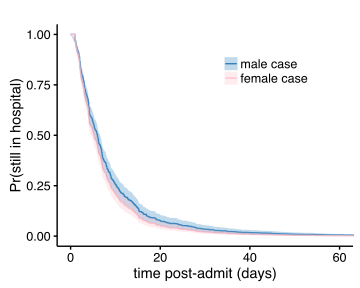

In [90]:
dummy.cdi_dx.cases <- rbind(dummy.cdi_dx.male[1,], dummy.cdi_dx.female[1,])
ggsurv(survfit(cox.cdi_dx, newdata=dummy.cdi_dx.cases), 
       CI=TRUE, xlab="time post-admit (days)", ylab="Pr(still in hospital)",
       gr.name="group", gr.labels=c("male case", "female case"),
       surv.col=c("#3182bd", "pink")) +
theme(legend.position=c(0.7, 0.8), legend.title=element_blank()) +
coord_cartesian(xlim=c(0, 60))

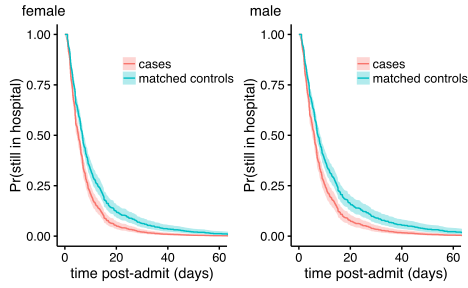

In [91]:
options(repr.plot.width=6.5, repr.plot.height=4)
gg.cdi_dx.female <- ggsurv(survfit(cox.cdi_dx, newdata=dummy.cdi_dx.female), 
                           CI=TRUE, xlab="time post-admit (days)", ylab="Pr(still in hospital)",
                           gr.name="group", gr.labels=c("cases", "matched controls")) +
                    theme(legend.position=c(0.7, 0.8), legend.title=element_blank()) +
                    coord_cartesian(xlim=c(0, 60))
gg.cdi_dx.male <- ggsurv(survfit(cox.cdi_dx, newdata=dummy.cdi_dx.male), 
                         CI=TRUE, xlab="time post-admit (days)", ylab="Pr(still in hospital)",
                         gr.name="group", gr.labels=c("cases", "matched controls")) +
                  theme(legend.position=c(0.7, 0.8), legend.title=element_blank()) +
                  coord_cartesian(xlim=c(0, 60))
gg <- plot_grid(gg.cdi_dx.female, gg.cdi_dx.male, labels=c("female", "male"), align = "h")
save_plot("data/analysis_3_coxph-cdi_dx.pdf", gg, base_height=3, base_aspect_ratio=1.3)
gg

Although at first this seems like a nice model with `cdi_statusmatched controls` having the most significant coefficient *and* a clear effect on average patients seen above, after doing some [model diagnostics](https://socserv.socsci.mcmaster.ca/jfox/Books/Companion/appendix/Appendix-Cox-Regression.pdf) we see strong evidence for violation of the proportional hazards assumption (see the GLOBAL *P* value below).

It's mainly because of `age` and `cdi_case` which have strong time dependencies.

In [92]:
cox.zph(cox.cdi_dx, transform=function(t) log(t + 50))

                rho chisq        p
propensity   0.0811  7.56 5.96e-03
age          0.1172 13.50 2.39e-04
genderMale   0.0435  1.72 1.90e-01
cdi_caseTRUE 0.1617 23.57 1.20e-06
GLOBAL           NA 44.45 5.17e-09

This plot shows that the effect of having CDI is strongest at the beginning of the visit, and it wanes over time—yet more evidence that time of CDI diagnosis affects the hazard.

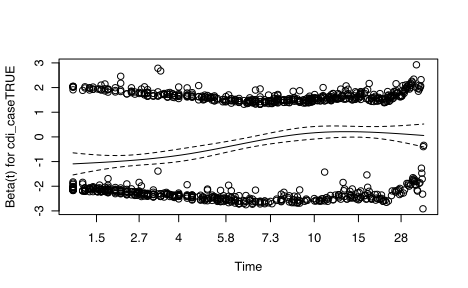

In [93]:
plot(cox.zph(cox.cdi_dx)[4])

Similarly, the coefficient for `age` has a trend vs. time.

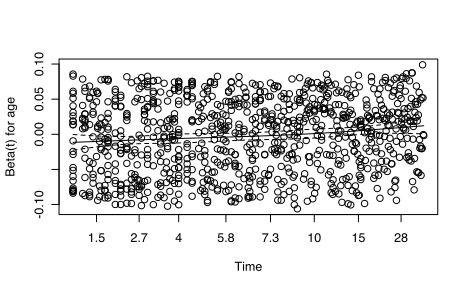

In [94]:
plot(cox.zph(cox.cdi_dx)[2])

We could try to correct for this by allowing coefficients to vary over time, but the worse underlying problem is that CDI status is being modeled as a baseline covariate instead of a time-dependent covariate. There's no way to fix that because visit diagnosis codes don't come with a timestamp when it became applicable during the visit. Therefore, we don't attempt any futher Cox modeling on this cohort.

This underlying problem might be correctable for the lab-based case definitions, though, which do have a timestamp (`cdtox_positive_after`).

## 1b. `cdtox_eia_positive = 'Y'`

First, the non-parametric Kaplan-Meier survival curves.

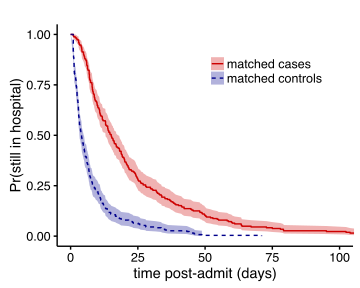

In [95]:
los.df.cdtox_eia <- los.m.df[los.m.df$case_def == 'cdtox_eia',]

surv.cdtox_eia <- Surv(los.df.cdtox_eia$length_of_stay, rep(1, nrow(los.df.cdtox_eia)))
options(repr.plot.width=5, repr.plot.height=4)
gg <- ggsurv(survfit(surv.cdtox_eia ~ cdi_status, data = los.df.cdtox_eia), 
             CI=TRUE, xlab="time post-admit (days)", ylab="Pr(still in hospital)", gr.name="group",
             surv.col=c("red3", "darkblue"), lty.est=c(1, 2)) +
      theme(legend.position=c(0.7, 0.8), legend.title=element_blank()) +
      coord_cartesian(xlim=c(0, 100))
save_plot("data/analysis_3_survival-cdtox_eia.pdf", gg, base_height=3, base_aspect_ratio=1.3)
gg

We first fit a Cox model with CDI status as a baseline covariate (not ideal, but worth seeing what happens).

In [96]:
S.cdtox_eia <- Surv(los.df.cdtox_eia$length_of_stay, rep(1, nrow(los.df.cdtox_eia)))
cox.cdtox_eia <- coxph(S.cdtox_eia ~ propensity + age + gender + cdi_status, data=los.df.cdtox_eia)
summary(cox.cdtox_eia)

Call:
coxph(formula = S.cdtox_eia ~ propensity + age + gender + cdi_status, 
    data = los.df.cdtox_eia)

  n= 528, number of events= 528 

                                 coef  exp(coef)   se(coef)      z Pr(>|z|)    
propensity                 -7.4065280  0.0006073  1.9756475 -3.749 0.000178 ***
age                        -0.0030818  0.9969230  0.0023349 -1.320 0.186869    
genderMale                 -0.0890345  0.9148140  0.0882906 -1.008 0.313250    
cdi_statusmatched controls  1.1608560  3.1926649  0.0957645 12.122  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                           exp(coef) exp(-coef) lower .95 upper .95
propensity                 0.0006073  1646.6991 1.264e-05   0.02918
age                        0.9969230     1.0031 9.924e-01   1.00150
genderMale                 0.9148140     1.0931 7.694e-01   1.08764
cdi_statusmatched controls 3.1926649     0.3132 2.646e+00   3.85184

Concordance= 0.687  (se = 0.015 )
Rsquare= 0.25   

Create dummy data for an "average" male and female case and control

In [97]:
dummy.cdtox_eia.female <- with(los.df.cdtox_eia,
                               data.frame(
                                   cdi_status=levels(cdi_status),
                                   age=mean(age),
                                   propensity=median(propensity),
                                   gender=rep(levels(gender)[1], 2)
                                   )
                               )
dummy.cdtox_eia.female
dummy.cdtox_eia.male <- with(los.df.cdtox_eia,
                             data.frame(
                                 cdi_status=levels(cdi_status),
                                 age=mean(age),
                                 propensity=median(propensity),
                                 gender=rep(levels(gender)[2], 2)
                                 )
                             )
dummy.cdtox_eia.male

cdi_status,age,propensity,gender
matched cases,62.30682,0.005739379,Female
matched controls,62.30682,0.005739379,Female


cdi_status,age,propensity,gender
matched cases,62.30682,0.005739379,Male
matched controls,62.30682,0.005739379,Male


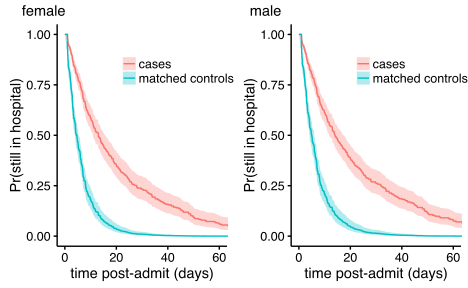

In [98]:
options(repr.plot.width=6.5, repr.plot.height=4)
gg.cdtox_eia.female <- ggsurv(survfit(cox.cdtox_eia, newdata=dummy.cdtox_eia.female), 
                              CI=TRUE, xlab="time post-admit (days)", ylab="Pr(still in hospital)",
                              gr.name="group", gr.labels=c("cases", "matched controls")) +
                       theme(legend.position=c(0.7, 0.8), legend.title=element_blank()) +
                       coord_cartesian(xlim=c(0, 60))
gg.cdtox_eia.male <- ggsurv(survfit(cox.cdtox_eia, newdata=dummy.cdtox_eia.male), 
                            CI=TRUE, xlab="time post-admit (days)", ylab="Pr(still in hospital)",
                            gr.name="group", gr.labels=c("cases", "matched controls")) +
                     theme(legend.position=c(0.7, 0.8), legend.title=element_blank()) +
                     coord_cartesian(xlim=c(0, 60))
gg <- plot_grid(gg.cdtox_eia.female, gg.cdtox_eia.male, labels=c("female", "male"), align = "h")
save_plot("data/analysis_3_coxph-cdtox_eia.pdf", gg, base_height=3.5, base_aspect_ratio=1.8)
gg

OK, there's a large contrast for both the female (left) and the male (right), but was the proportional hazards assumption violated?

In [99]:
cox.zph.cdtox_eia <- cox.zph(cox.cdtox_eia)
cox.zph.cdtox_eia

                               rho chisq        p
propensity                  0.0444  1.39 2.39e-01
age                         0.0526  1.50 2.20e-01
genderMale                 -0.0259  0.36 5.49e-01
cdi_statusmatched controls -0.2209 24.35 8.05e-07
GLOBAL                          NA 25.67 3.69e-05

Yes, it was; the GLOBAL *P* value is << 0.05, and we can see that there is definitely some time dependency on CDI status.

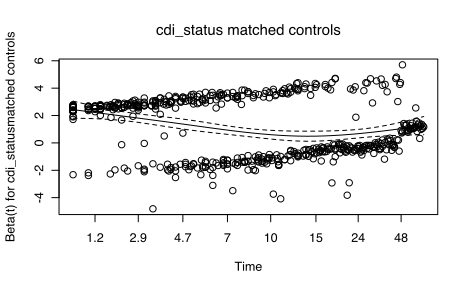

In [100]:
plot(cox.zph.cdtox_eia[4], main="cdi_status matched controls")

We could try to reshape the data to make CDI status a time-dependent covariate, but our attempts to do this still could not satisfy the proportional-hazards assumption. This leaves open the approach of modeling $\beta$ for CDI status as a time-dependent function, but selecting this function is a completely arbitrary modeling choice that the above plot doesn't give much direction on. In the interest of keeping our analysis simple and generalizable, we didn't proceed down that route.

## 1c. `cdtox_pcr_positive = TRUE`

Since the Cox models did not achieve good fits above, for the rest of the notebook we stick with the nonparametric Kaplan-Meier plots.

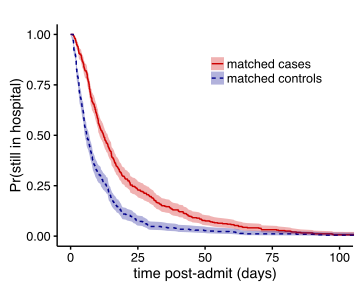

In [108]:
los.df.cdtox_pcr <- los.m.df[los.m.df$case_def == 'cdtox_pcr',]

surv.cdtox_pcr <- Surv(los.df.cdtox_pcr$length_of_stay, rep(1, nrow(los.df.cdtox_pcr)))
options(repr.plot.width=5, repr.plot.height=4)
gg <- ggsurv(survfit(surv.cdtox_pcr ~ cdi_status, data = los.df.cdtox_pcr), 
             CI=TRUE, xlab="time post-admit (days)", ylab="Pr(still in hospital)", gr.name="group",
             surv.col=c("red3", "darkblue"), lty.est=c(1, 2)) +
      theme(legend.position=c(0.7, 0.8), legend.title=element_blank()) +
      coord_cartesian(xlim=c(0, 100))
save_plot("data/analysis_3_survival-cdtox_pcr.pdf", gg, base_height=3, base_aspect_ratio=1.3)
gg

## 1d. either 1b OR 1c

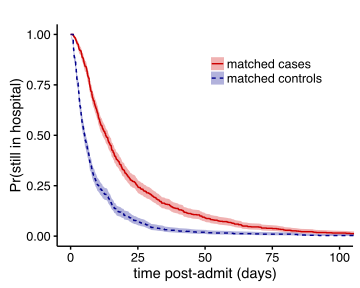

In [109]:
los.df.cdtox_all <- los.m.df[los.m.df$case_def == 'cdtox_all',]

surv.cdtox_all <- Surv(los.df.cdtox_all$length_of_stay, rep(1, nrow(los.df.cdtox_all)))
options(repr.plot.width=5, repr.plot.height=4)
gg <- ggsurv(survfit(surv.cdtox_all ~ cdi_status, data = los.df.cdtox_all), 
             CI=TRUE, xlab="time post-admit (days)", ylab="Pr(still in hospital)", gr.name="group",
             surv.col=c("red3", "darkblue"), lty.est=c(1, 2)) +
      theme(legend.position=c(0.7, 0.8), legend.title=element_blank()) +
      coord_cartesian(xlim=c(0, 100))
save_plot("data/analysis_3_survival-cdtox_all.pdf", gg, base_height=3, base_aspect_ratio=1.3)
gg

In [110]:
S.cdtox_all <- Surv(los.df.cdtox_all$length_of_stay, rep(1, nrow(los.df.cdtox_all)))
cox.cdtox_all <- coxph(S.cdtox_all ~ propensity + age + gender + cdi_status, data=los.df.cdtox_all)
summary(cox.cdtox_all)

Call:
coxph(formula = S.cdtox_all ~ propensity + age + gender + cdi_status, 
    data = los.df.cdtox_all)

  n= 1444, number of events= 1444 

                                coef exp(coef)  se(coef)      z Pr(>|z|)    
propensity                 -5.367545  0.004666  0.872276 -6.153 7.58e-10 ***
age                        -0.001500  0.998501  0.001465 -1.024   0.3059    
genderMale                 -0.124297  0.883118  0.053159 -2.338   0.0194 *  
cdi_statusmatched controls  0.824640  2.281061  0.054856 15.033  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                           exp(coef) exp(-coef) lower .95 upper .95
propensity                  0.004666   214.3360 0.0008442   0.02579
age                         0.998501     1.0015 0.9956383   1.00137
genderMale                  0.883118     1.1324 0.7957362   0.98009
cdi_statusmatched controls  2.281061     0.4384 2.0485342   2.53998

Concordance= 0.661  (se = 0.009 )
Rsquare= 0.159   (max possibl

## 1e. either 1a OR 1b OR 1c

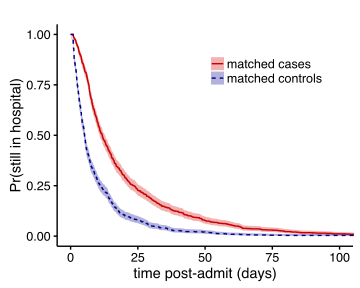

In [111]:
los.df.cdi_union <- los.m.df[los.m.df$case_def == 'cdi_union',]

surv.cdi_union <- Surv(los.df.cdi_union$length_of_stay, rep(1, nrow(los.df.cdi_union)))
options(repr.plot.width=5, repr.plot.height=4)
gg <- ggsurv(survfit(surv.cdi_union ~ cdi_status, data = los.df.cdi_union), 
             CI=TRUE, xlab="time post-admit (days)", ylab="Pr(still in hospital)", gr.name="group",
             surv.col=c("red3", "darkblue"), lty.est=c(1, 2)) +
      theme(legend.position=c(0.7, 0.8), legend.title=element_blank()) +
      coord_cartesian(xlim=c(0, 100))
save_plot("data/analysis_3_survival-cdi_union.pdf", gg, base_height=3, base_aspect_ratio=1.3)
gg

# 2. Stratified by time of diagnosis

In [ ]:
load("data/analysis_3_matchit-los-dxtime-m-df.RData")

In [ ]:
los.dx_time.m.df <- los.dx_time.m.df[los.dx_time.m.df$cdi_status %in% c("matched cases", "matched controls"),]
los.dx_time.m.df$cdi_status <- factor(as.character(los.dx_time.m.df$cdi_status))
los.dx_time.m.df$gender <- factor(as.character(los.dx_time.m.df$gender))

In [121]:
los.dx_time.m.df$length_of_stay <- round(pmax(los.dx_time.m.df$length_of_stay, 1), 1)
los.dx_time.m.df$cdtox_positive_after <- round(pmax(0.5,
                                            pmin(los.dx_time.m.df$length_of_stay - 0.5,
                                                 los.dx_time.m.df$cdtox_positive_after)), 1)
summary(los.dx_time.m.df$length_of_stay)
summary(los.dx_time.m.df$cdtox_positive_after)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   5.925  10.900  18.170  20.300 398.100 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.500   1.800   5.300   9.481  10.900 250.300     629 

## 2a. 1d AND `cdtox_positive_at < 3`

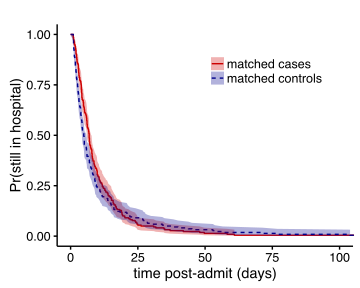

In [122]:
los.df.cdtox_all.CA <- los.dx_time.m.df[los.dx_time.m.df$case_def == 'cdtox_all.CA',]

surv.cdtox_all.CA <- Surv(los.df.cdtox_all.CA$length_of_stay, rep(1, nrow(los.df.cdtox_all.CA)))
options(repr.plot.width=5, repr.plot.height=4)
gg <- ggsurv(survfit(surv.cdtox_all.CA ~ cdi_status, data = los.df.cdtox_all.CA), 
             CI=TRUE, xlab="time post-admit (days)", ylab="Pr(still in hospital)", gr.name="group",
             surv.col=c("red3", "darkblue"), lty.est=c(1, 2)) +
      theme(legend.position=c(0.7, 0.8), legend.title=element_blank()) +
      coord_cartesian(xlim=c(0, 100))
save_plot("data/analysis_3_survival-cdtox_all-CA.pdf", gg, base_height=3, base_aspect_ratio=1.3)
gg

## 2b. 1d AND `3 ≤ cdtox_positive_at < 8`

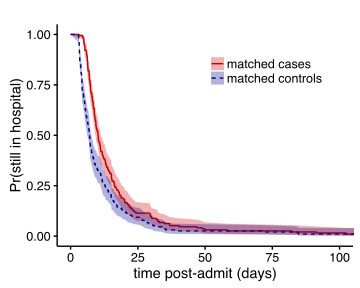

In [123]:
los.df.cdtox_all.HA_early <- los.dx_time.m.df[los.dx_time.m.df$case_def == 'cdtox_all.HA_early',]

surv.cdtox_all.HA_early <- Surv(los.df.cdtox_all.HA_early$length_of_stay, rep(1, nrow(los.df.cdtox_all.HA_early)))
options(repr.plot.width=5, repr.plot.height=4)
gg <- ggsurv(survfit(surv.cdtox_all.HA_early ~ cdi_status, data = los.df.cdtox_all.HA_early), 
             CI=TRUE, xlab="time post-admit (days)", ylab="Pr(still in hospital)", gr.name="group",
             surv.col=c("red3", "darkblue"), lty.est=c(1, 2)) +
      theme(legend.position=c(0.7, 0.8), legend.title=element_blank()) +
      coord_cartesian(xlim=c(0, 100))
save_plot("data/analysis_3_survival-cdtox_all-HA_early.pdf", gg, base_height=3, base_aspect_ratio=1.3)
gg

## 2c. 1d AND `cdtox_positive_at ≥ 8`

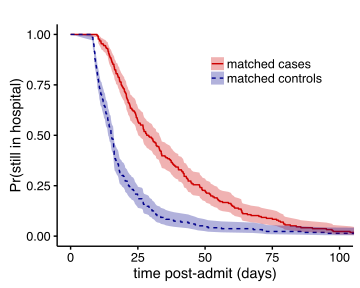

In [124]:
los.df.cdtox_all.HA_late <- los.dx_time.m.df[los.dx_time.m.df$case_def == 'cdtox_all.HA_late',]

surv.cdtox_all.HA_late <- Surv(los.df.cdtox_all.HA_late$length_of_stay, rep(1, nrow(los.df.cdtox_all.HA_late)))
options(repr.plot.width=5, repr.plot.height=4)
gg <- ggsurv(survfit(surv.cdtox_all.HA_late ~ cdi_status, data = los.df.cdtox_all.HA_late), 
             CI=TRUE, xlab="time post-admit (days)", ylab="Pr(still in hospital)", gr.name="group",
             surv.col=c("red3", "darkblue"), lty.est=c(1, 2)) +
      theme(legend.position=c(0.7, 0.8), legend.title=element_blank()) +
      coord_cartesian(xlim=c(0, 100))
save_plot("data/analysis_3_survival-cdtox_all-HA_late.pdf", gg, base_height=3, base_aspect_ratio=1.3)
gg